In [1]:
"""
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
"""

'\n# This Python 3 environment comes with many helpful analytics libraries installed\n# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python\n# For example, here\'s several helpful packages to load\n\nimport numpy as np # linear algebra\nimport pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)\n\n# Input data files are available in the read-only "../input/" directory\n# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory\n\nimport os\nfor dirname, _, filenames in os.walk(\'/kaggle/input\'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n\n# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" \n# You can also write temporary files to /kaggle/temp/, but they won\'t be saved outside of the current session\n'

In [1]:
# path="others/"
# initial_lgb_submission = pd.read_csv(path+'initial_lgb_submission.csv')
# initial_lgb_submission

In [ ]:
# blended_submission1 = pd.read_csv(path+'blended_submission1.csv')
# blended_submission1

# 데이터 로드 및 훈련, 테스트 데이터 확인

In [40]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
import warnings
warnings.filterwarnings(action='ignore')

In [41]:
# Basic data loading
path = "/home/aiffel/aiffel/Hackathon/"

df_train = pd.read_csv(path + 'sales_train.csv')
df_test = pd.read_csv(path + 'test.csv', index_col='ID')
df_shops = pd.read_csv(path + 'shops.csv', index_col='shop_id')
df_items = pd.read_csv(path + 'items.csv', index_col='item_id')
df_itemcat = pd.read_csv(path + 'item_categories.csv', index_col='item_category_id')
sample_submission = pd.read_csv(path + 'sample_submission.csv', index_col='ID')

In [42]:
# 시험용으로 변수 수 줄이기
# df_train_drop = df_train[:int(df_train.shape[0]/10)]

In [43]:
# df_train_drop

In [44]:
from sklearn.preprocessing import LabelEncoder
from datetime import datetime

def date_processing(df):
    df["date"] = df["date"].apply(lambda date_str : datetime.strptime(date_str, "%d.%m.%Y"))

    df["year"] = df["date"].apply(lambda date : date.year)
    df["month"] = df["date"].apply(lambda date : date.month)
    df["day"] = df["date"].apply(lambda date : date.day)
    df = df.drop(columns=["date"])
    df = df[["year", "month","day", "date_block_num", "shop_id", "item_id",
             "item_price", "item_cnt_day"]]
    return df

df_train_preprocessed = df_train
df_train_preprocessed = date_processing(df_train_preprocessed)
df_train_preprocessed.head()

,year,month,day,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013,1,2,0,59,22154,999.00,1.0
1,2013,1,3,0,25,2552,899.00,1.0
2,2013,1,5,0,25,2552,899.00,-1.0
3,2013,1,6,0,25,2554,1709.05,1.0
4,2013,1,15,0,25,2555,1099.00,1.0


In [45]:
df_train_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   year            int64  
 1   month           int64  
 2   day             int64  
 3   date_block_num  int64  
 4   shop_id         int64  
 5   item_id         int64  
 6   item_price      float64
 7   item_cnt_day    float64
dtypes: float64(2), int64(6)
memory usage: 179.2 MB


In [46]:
df_train_preprocessed

,year,month,day,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013,1,2,0,59,22154,999.00,1.0
1,2013,1,3,0,25,2552,899.00,1.0
2,2013,1,5,0,25,2552,899.00,-1.0
3,2013,1,6,0,25,2554,1709.05,1.0
4,2013,1,15,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...,...,...
2935844,2015,10,10,33,25,7409,299.00,1.0
2935845,2015,10,9,33,25,7460,299.00,1.0
2935846,2015,10,14,33,25,7459,349.00,1.0
2935847,2015,10,22,33,25,7440,299.00,1.0


## 시각화를 진행하며 데이터를 파악해봅시다.

In [47]:
# 시각화를 어떻게 해야 하나
train = df_train_preprocessed.copy()
display(train.head())
train.shape

print(sorted(train.shop_id.unique())) # shop_id 리스트를 봅시다
print("총 shop_id 개수는",len(train.shop_id.unique()),"개 입니당")

,year,month,day,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013,1,2,0,59,22154,999.00,1.0
1,2013,1,3,0,25,2552,899.00,1.0
2,2013,1,5,0,25,2552,899.00,-1.0
3,2013,1,6,0,25,2554,1709.05,1.0
4,2013,1,15,0,25,2555,1099.00,1.0


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
총 shop_id 개수는 60 개 입니당


,shop_id,year,month,item_cnt_day
0,0,2013,1,5578.0
1,0,2013,2,6127.0
2,1,2013,1,2947.0
3,1,2013,2,3364.0
4,2,2013,1,1146.0


(547, 4)


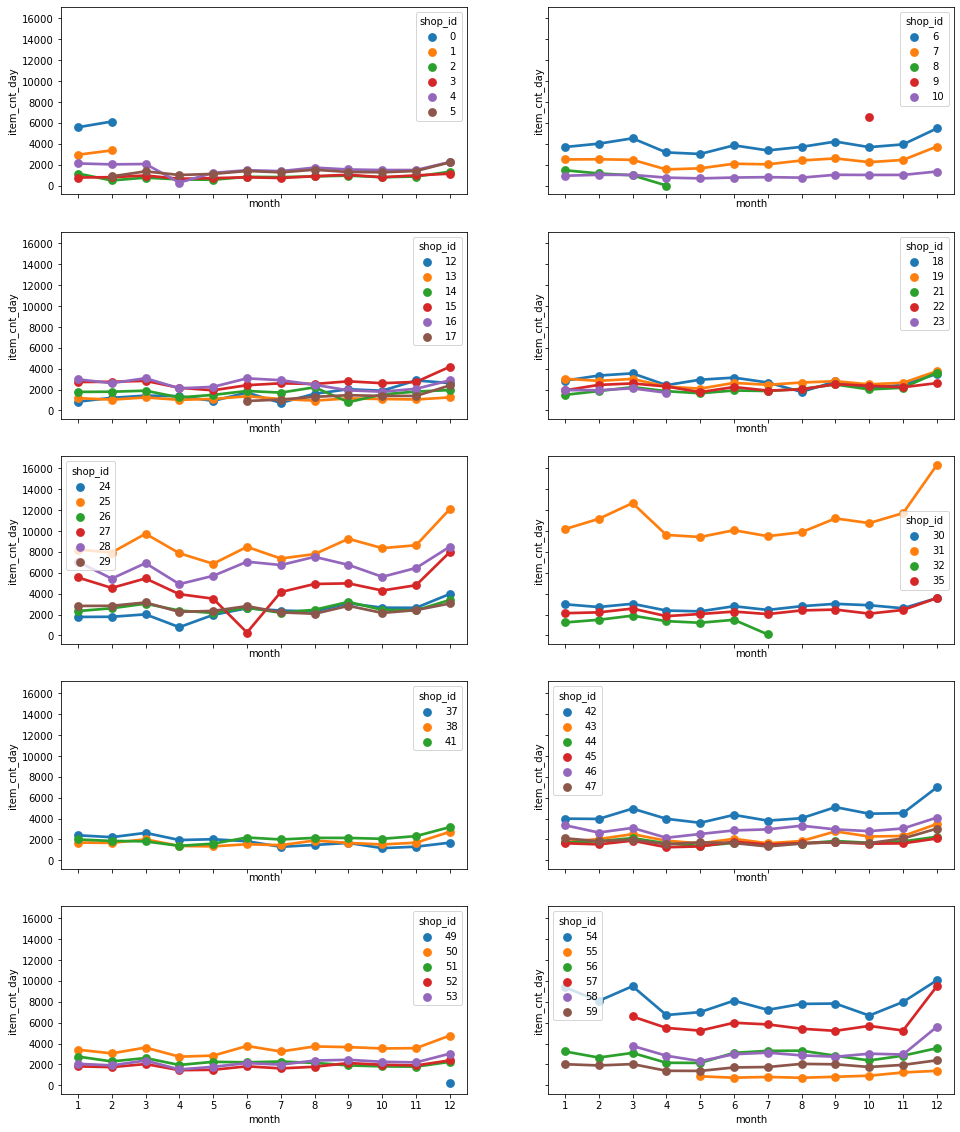

In [48]:
# 훈련데이터 중에서 shop_id 컬럼과 year, month를 기준으로 묶은 뒤, item_cnt_dat를 모두 더합니다. 그 뒤 인덱스를 리셋합니다.
def group(df, year=2013) :
    grouped = pd.DataFrame(df.groupby(['shop_id', 'year', 'month'])['item_cnt_day'].sum().reset_index())
    grouped = grouped.groupby(['year']).get_group(year)
    return grouped

grouped = group(train,2013)
display(grouped.head())
print(grouped.shape)

# 2013년 그래프를 그려봅시다!! 
# shop을 기준으로 그립니다!!
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))
num_graph = 10
id_per_graph = ceil(grouped.shop_id.max() / num_graph) 
count = 0 # 순서 넘어갈 때 인덱스로 사용


# 아까와 동일하게 그린다. 
# 다만 시간대는 x축은 momth로 주고, y축은 일일 판매량 그대로이다. 데이터는 가게 아이디로 한다.
for i in range(5):
    for j in range(2):
        sns.pointplot(x='month', y='item_cnt_day', hue='shop_id', 
                      data=grouped[np.logical_and(count*id_per_graph <= grouped['shop_id'], grouped['shop_id'] < (count+1)*id_per_graph)], ax=axes[i][j])
        count += 1


,shop_id,year,month,item_cnt_day
16,2,2014,1,890.0
17,2,2014,2,911.0
18,2,2014,3,990.0
19,2,2014,4,791.0
20,2,2014,5,910.0


(590, 4)


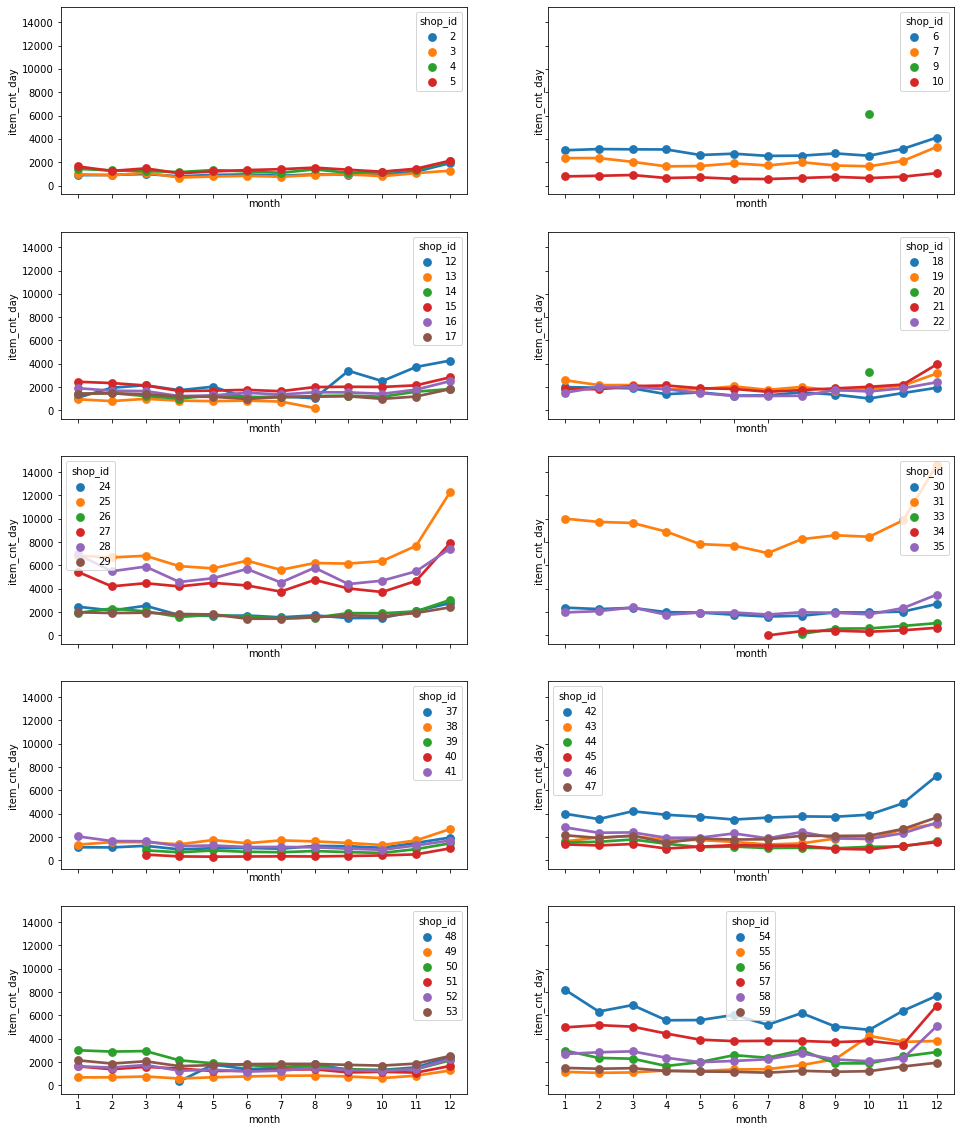

In [49]:
# 2014년 그래프를 그려봅시다!! 
grouped = group(train,2014)
display(grouped.head())
print(grouped.shape)

# shop을 기준으로 그립니다!!
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))
num_graph = 10
id_per_graph = ceil(grouped.shop_id.max() / num_graph)
count = 0 # 순서 넘어갈 때 인덱스로 사용


# 아까와 동일하게 그린다. 
# 다만 시간대는 x축은 momth로 주고, y축은 일일 판매량 그대로이다. 데이터는 가게 아이디로 한다.
for i in range(5):
    for j in range(2):
        sns.pointplot(x='month', y='item_cnt_day', hue='shop_id', 
                      data=grouped[np.logical_and(count*id_per_graph <= grouped['shop_id'], grouped['shop_id'] < (count+1)*id_per_graph)], ax=axes[i][j])
        count += 1

,shop_id,year,month,item_cnt_day
28,2,2015,1,987.0
29,2,2015,2,907.0
30,2,2015,3,762.0
31,2,2015,4,859.0
32,2,2015,5,843.0


(449, 4)


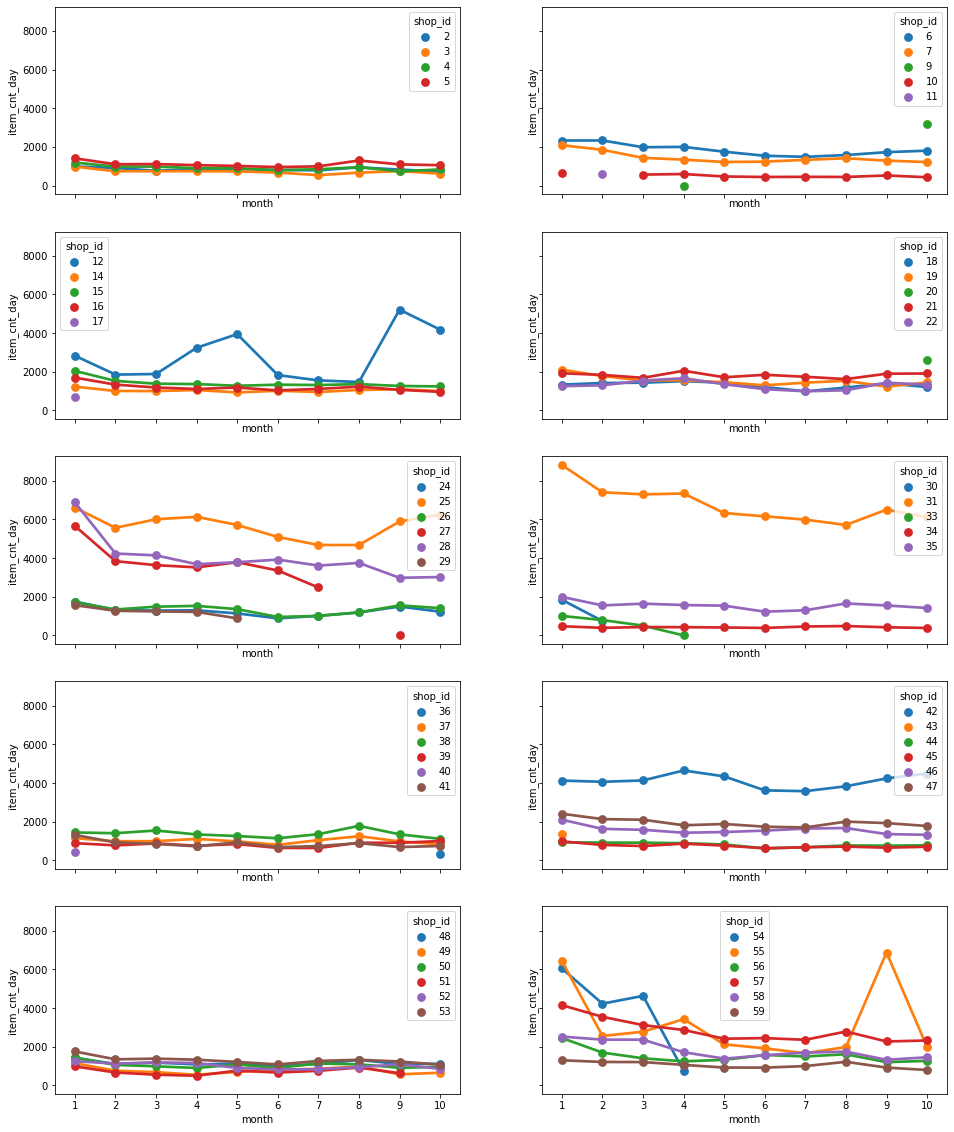

In [50]:
# 2015년 그래프를 그려봅시다!! 
grouped = group(train,2015)
display(grouped.head())
print(grouped.shape)

# shop을 기준으로 그립니다!!
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))
num_graph = 10
id_per_graph = ceil(grouped.shop_id.max() / num_graph)
count = 0 # 순서 넘어갈 때 인덱스로 사용


# 아까와 동일하게 그린다. 
# 다만 시간대는 x축은 momth로 주고, y축은 일일 판매량 그대로이다. 데이터는 가게 아이디로 한다.
for i in range(5):
    for j in range(2):
        sns.pointplot(x='month', y='item_cnt_day', hue='shop_id', 
                      data=grouped[np.logical_and(count*id_per_graph <= grouped['shop_id'], grouped['shop_id'] < (count+1)*id_per_graph)], ax=axes[i][j])
        count += 1

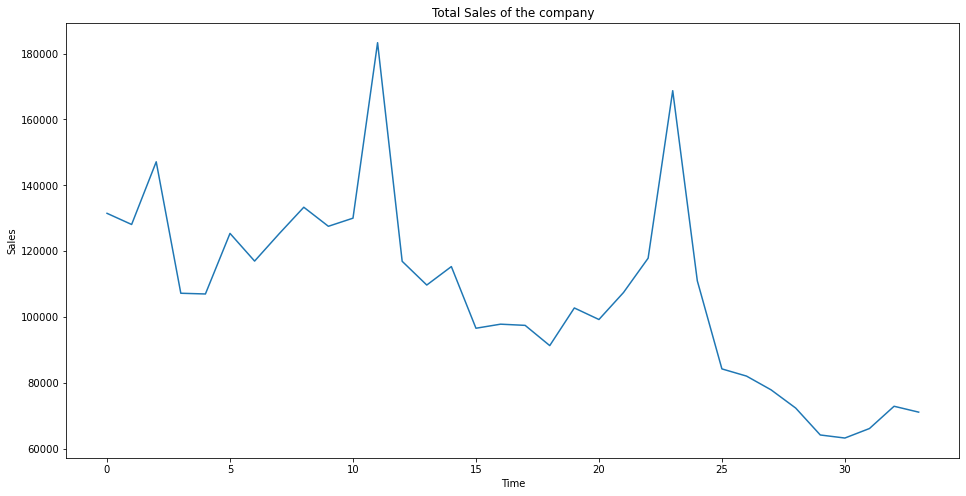

In [51]:
## 12월에만 특히 매출이 급상승하는 듯?? 
## 이를 확인해봅시다.
## https://www.kaggle.com/raoyama/time-series-basics-exploring-traditional-ts 참고


total=df_train.groupby(["date_block_num"])["item_cnt_day"].sum()
total.astype('float')
plt.figure(figsize=(16,8))
plt.title('Total Sales of the company')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(total);

## 2013년 12월과 2014년 12월에 피크를 찍는다. 

<AxesSubplot:ylabel='year'>

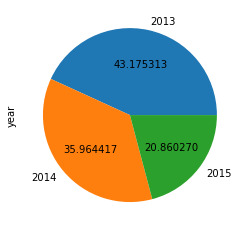

In [52]:
# 그럼 해당 연별 비중은 어떻게 될까요
# https://www.kaggle.com/mohammadhy/eda-usefull 참고
df_train_preprocessed['year'].value_counts().plot(kind='pie', autopct='%f') # 위의 그래프를 보면 비슷한 것 같기도...?

# 문제는 train 데이터에는 test 데이터에 해당되는 것 외에도 다른 데이터가 존재
## test데이터에 해당하는 train 데이터로만 시각화를 한다면?

In [53]:
# train 데이터 재설정
train = df_train_preprocessed.copy()
display(train.head())
train.shape

,year,month,day,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013,1,2,0,59,22154,999.00,1.0
1,2013,1,3,0,25,2552,899.00,1.0
2,2013,1,5,0,25,2552,899.00,-1.0
3,2013,1,6,0,25,2554,1709.05,1.0
4,2013,1,15,0,25,2555,1099.00,1.0


(2935849, 8)

In [54]:
# train데이터 중 test데이터에 있는 shop_id만 남깁니다.
df_test_shops = df_test.shop_id.unique()
df_train = train[train.shop_id.isin(df_test_shops)]
print("shop_id 전처리 후 :",df_train.shape) # 2935849 -> 2413246

# train데이터 중 test데이터에 있는 item_id만 남깁니다.
df_test_items = df_test.item_id.unique()
df_train = df_train[df_train.item_id.isin(df_test_items)]
print("item_id 전처리 후 :",df_train.shape) # 2413246 -> 1224439

shop_id 전처리 후 : (2413246, 8)
item_id 전처리 후 : (1224439, 8)


In [55]:
print(sorted(df_train.shop_id.unique())) # shop_id 리스트를 봅시다
print("총 shop_id 개수는",len(df_train.shop_id.unique()),"개 입니당")

[2, 3, 4, 5, 6, 7, 10, 12, 14, 15, 16, 18, 19, 21, 22, 24, 25, 26, 28, 31, 34, 35, 36, 37, 38, 39, 41, 42, 44, 45, 46, 47, 48, 49, 50, 52, 53, 55, 56, 57, 58, 59]
총 shop_id 개수는 42 개 입니당


,shop_id,year,month,item_cnt_day
0,2,2013,1,248.0
1,2,2013,2,135.0
2,2,2013,3,237.0
3,2,2013,4,168.0
4,2,2013,5,159.0


(436, 4)


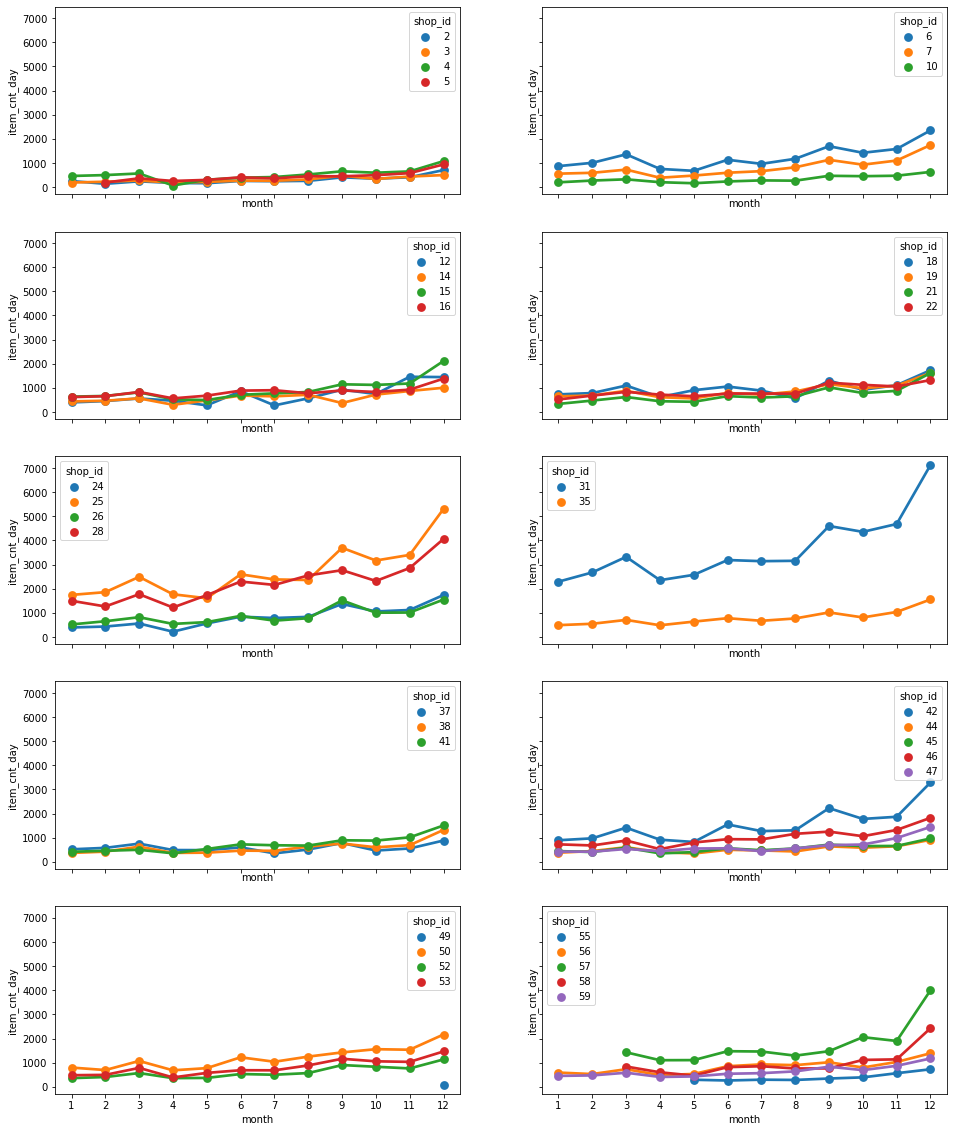

In [56]:
# 시각화를 어떻게 해야 하나
train = df_train.copy()

# 훈련데이터 중에서 shop_id 컬럼과 year, month를 기준으로 묶은 뒤, item_cnt_dat를 모두 더합니다. 그 뒤 인덱스를 리셋합니다.
def group(df, year=2013) :
    grouped = pd.DataFrame(df.groupby(['shop_id', 'year', 'month'])['item_cnt_day'].sum().reset_index())
    grouped = grouped.groupby(['year']).get_group(year)
    return grouped

grouped = group(train,2013)
display(grouped.head())
print(grouped.shape)

# 2013년 그래프를 그려봅시다!! 
# shop을 기준으로 그립니다!!
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))
num_graph = 10
id_per_graph = ceil(grouped.shop_id.max() / num_graph)
count = 0 # 순서 넘어갈 때 인덱스로 사용


# 아까와 동일하게 그린다. 
# 다만 시간대는 x축은 momth로 주고, y축은 일일 판매량 그대로이다. 데이터는 가게 아이디로 한다.
for i in range(5):
    for j in range(2):
        sns.pointplot(x='month', y='item_cnt_day', hue='shop_id', 
                      data=grouped[np.logical_and(count*id_per_graph <= grouped['shop_id'], grouped['shop_id'] < (count+1)*id_per_graph)], ax=axes[i][j])
        count += 1

,shop_id,year,month,item_cnt_day
12,2,2014,1,442.0
13,2,2014,2,480.0
14,2,2014,3,590.0
15,2,2014,4,422.0
16,2,2014,5,540.0


(481, 4)


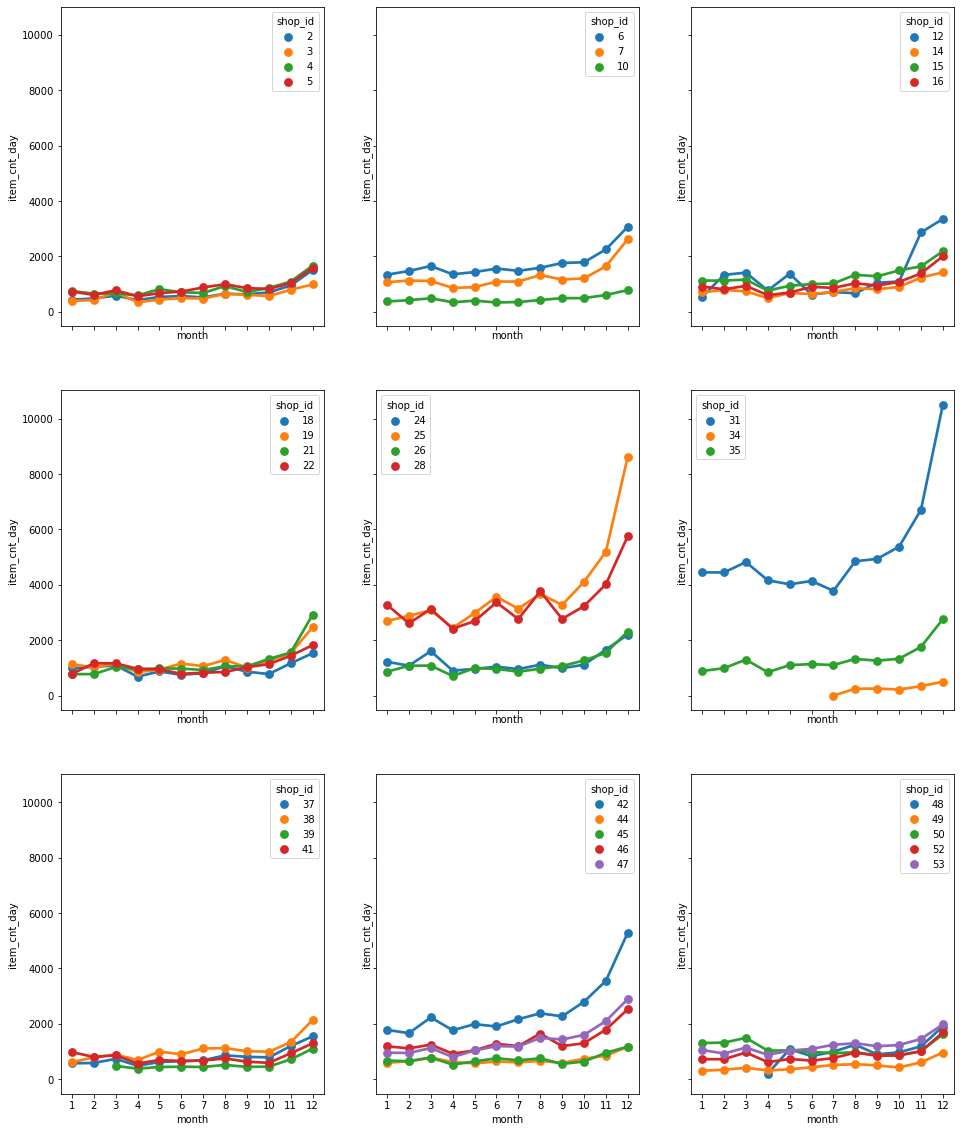

In [57]:
# 2014년 그래프를 그려봅시다!! 
grouped = group(train,2014)
display(grouped.head())
print(grouped.shape)

# shop을 기준으로 그립니다!!
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))
num_graph = 10
id_per_graph = ceil(grouped.shop_id.max() / num_graph) 
count = 0 # 순서 넘어갈 때 인덱스로 사용


# 아까와 동일하게 그린다. 
# 다만 시간대는 x축은 momth로 주고, y축은 일일 판매량 그대로이다. 데이터는 가게 아이디로 한다.
for i in range(5):
    for j in range(2):
        sns.pointplot(x='month', y='item_cnt_day', hue='shop_id', 
                      data=grouped[np.logical_and(count*id_per_graph <= grouped['shop_id'], grouped['shop_id'] < (count+1)*id_per_graph)], ax=axes[i][j])
        count += 1

,shop_id,year,month,item_cnt_day
24,2,2015,1,806.0
25,2,2015,2,765.0
26,2,2015,3,609.0
27,2,2015,4,743.0
28,2,2015,5,732.0


(410, 4)


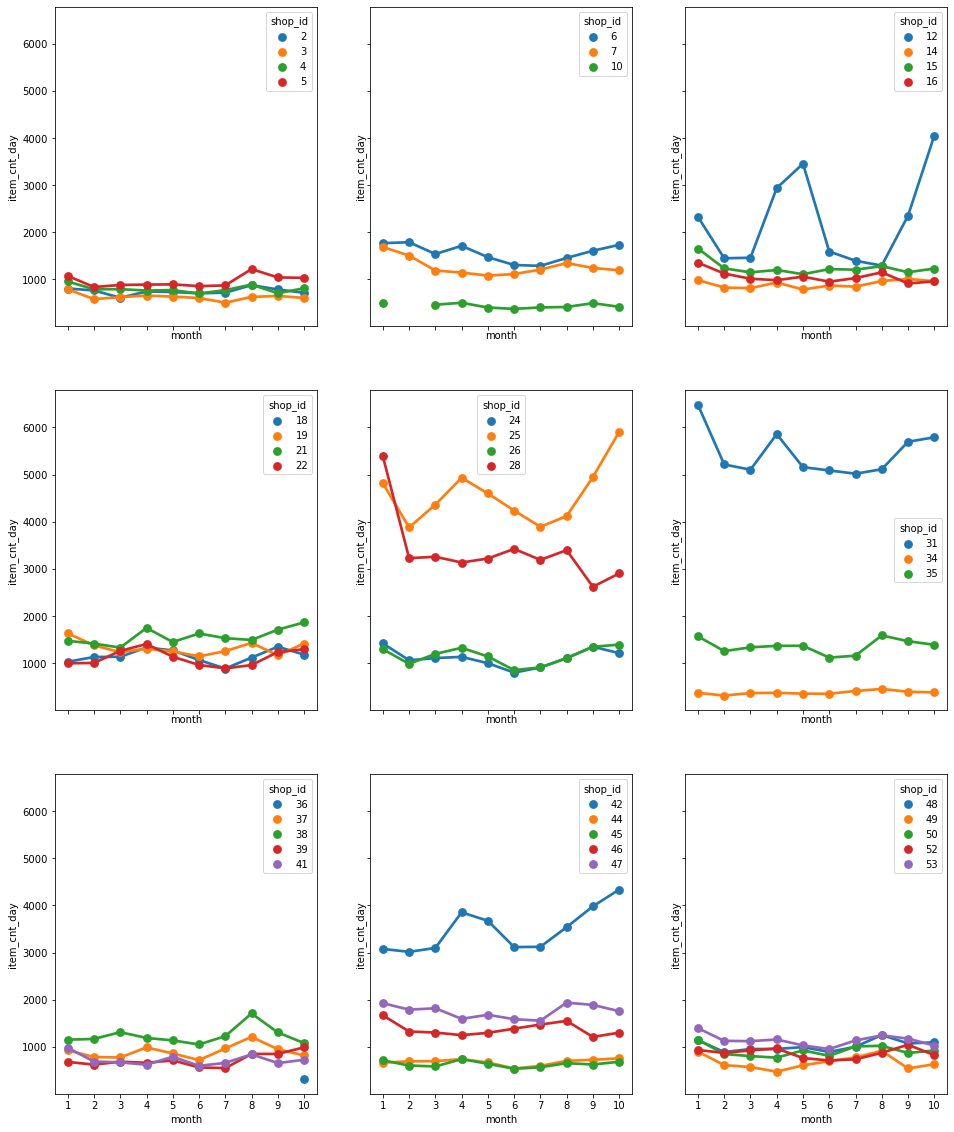

In [58]:
# 2015년 그래프를 그려봅시다!! 
grouped = group(train,2015)
display(grouped.head())
print(grouped.shape)

# shop을 기준으로 그립니다!!
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))
num_graph = 10
id_per_graph = ceil(grouped.shop_id.max() / num_graph) 
count = 0 # 순서 넘어갈 때 인덱스로 사용


# 아까와 동일하게 그린다. 
# 다만 시간대는 x축은 momth로 주고, y축은 일일 판매량 그대로이다. 데이터는 가게 아이디로 한다.
for i in range(5):
    for j in range(2):
        sns.pointplot(x='month', y='item_cnt_day', hue='shop_id', 
                      data=grouped[np.logical_and(count*id_per_graph <= grouped['shop_id'], grouped['shop_id'] < (count+1)*id_per_graph)], ax=axes[i][j])
        count += 1

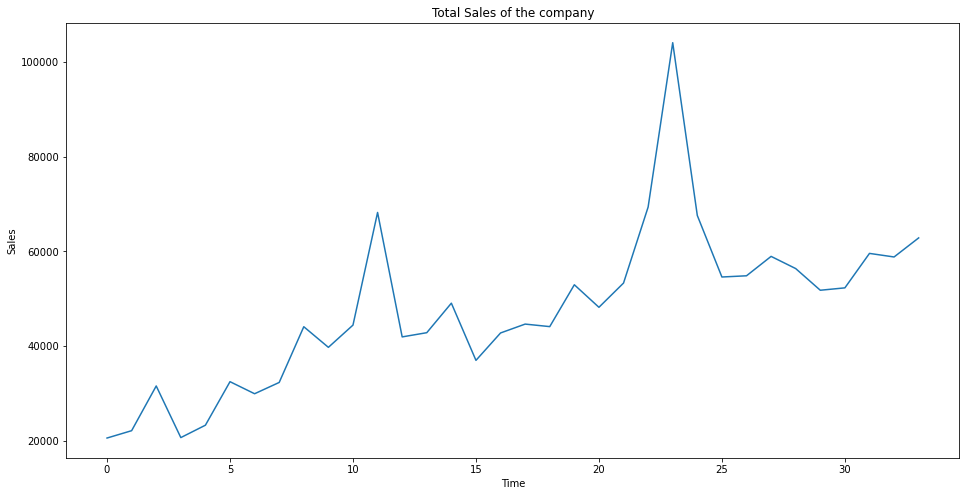

In [59]:
## 12월에만 특히 매출이 급상승하는 듯?? 
## 이를 확인해봅시다.
## https://www.kaggle.com/raoyama/time-series-basics-exploring-traditional-ts 참고


total=df_train.groupby(["date_block_num"])["item_cnt_day"].sum()
total.astype('float')
plt.figure(figsize=(16,8))
plt.title('Total Sales of the company')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(total);

## 2013년 12월과 2014년 12월에 피크를 찍는다. 

<AxesSubplot:ylabel='year'>

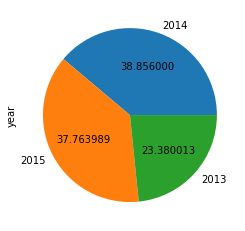

In [60]:
# 그럼 해당 연별 비중은 어떻게 될까요
# https://www.kaggle.com/mohammadhy/eda-usefull 참고
df_train['year'].value_counts().plot(kind='pie', autopct='%f') 

## 시각화 내용 정리
- 전체 훈련데이터의 경우
1. shop_id : 60개
2. 데이터 크기 : (547, 4) / (590, 4) / (449, 4)
3.

- 테스트데이터와 공통된 훈련데이터의 경우
1. shop_id : 42개
2. (436, 4) / (481, 4) / (410, 4)
3.


## 시각화 인사이트

12월 혹은 연초에 급격하게 판매량이 증가하는 경우가 발생 (크리스마스 등의 행사인 듯)      
하지만 11월도 12월의 증가세에 따라 같이 미약하게나마 증가하는 경향을 갖기 때문에 그대로 두는 것이 좋을 듯 하다.         
또한 일일 판매량으로 두기 보다는 월별 판매량으로 묶는 전처리가 필요해보인다.

In [18]:
#df_train_preprocessed["item_cnt_month"] = df_train_preprocessed.groupby(["year", "month", "shop_id", "item_id"])["item_cnt_day"].sum().reset_index()["item_cnt_day"]

In [15]:
cols = ["year", "month","date_block_num", "shop_id", "item_id"]
df_train_month = df_train_preprocessed.groupby(cols)["item_cnt_day"].sum().reset_index()

In [16]:
df_train_month

,year,month,date_block_num,shop_id,item_id,item_cnt_day
0,2013,1,0,0,32,6.0
1,2013,1,0,0,33,3.0
2,2013,1,0,0,35,1.0
3,2013,1,0,0,43,1.0
4,2013,1,0,0,51,2.0
...,...,...,...,...,...,...
1609119,2015,10,33,59,22087,6.0
1609120,2015,10,33,59,22088,2.0
1609121,2015,10,33,59,22091,1.0
1609122,2015,10,33,59,22100,1.0


In [17]:
df_train_month = df_train_month.rename(columns={"item_cnt_day": "item_cnt_month"})
df_train_month

,year,month,date_block_num,shop_id,item_id,item_cnt_month
0,2013,1,0,0,32,6.0
1,2013,1,0,0,33,3.0
2,2013,1,0,0,35,1.0
3,2013,1,0,0,43,1.0
4,2013,1,0,0,51,2.0
...,...,...,...,...,...,...
1609119,2015,10,33,59,22087,6.0
1609120,2015,10,33,59,22088,2.0
1609121,2015,10,33,59,22091,1.0
1609122,2015,10,33,59,22100,1.0


In [13]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
random_state = 200

month_X = df_train_month.iloc[:,:5]
month_y = df_train_month.iloc[:,5]

def month_predict(model, month_X, month_y, kind="default", print_len=7):
    X_train, X_val, y_train, y_val = train_test_split(month_X, month_y, test_size=0.2, random_state=random_state)
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    model_name = model.__class__.__name__
    print("#### " +model_name+" month prediction("+kind+") ####")
    print("y_train[:{}] : {}".format(print_len, np.round(y_train[:print_len].values,1)))
    print("y_pred_train[:{}] : {}".format(print_len, np.round(y_pred_train[:print_len],1)))
    print()
    y_pred_val = model.predict(X_val)
    print("y_val[:{}] : {}".format(print_len, np.round(y_val[:print_len].values,1)))
    print("y_pred_val[:{}] : {}".format(print_len, np.round(y_pred_val[:print_len],1)))
    rmse = np.sqrt(mean_squared_error(y_pred_val, y_val))
    print("rmse : {:.6f}".format(rmse))
    print("----------\n")
    return model

In [14]:
from sklearn.ensemble import RandomForestRegressor
month_regressor = RandomForestRegressor(random_state=random_state)
month_regressor = month_predict(month_regressor, month_X, month_y)

#### RandomForestRegressor month prediction(default) ####
y_train[:7] : [1. 1. 1. 3. 1. 2. 1.]
y_pred_train[:7] : [1.4 1.1 1.  3.9 1.9 1.7 1.1]

y_val[:7] : [4. 7. 1. 8. 2. 8. 3.]
y_pred_val[:7] : [2.7 4.7 2.1 3.6 1.1 5.6 1.7]
rmse : 2.942642
----------



In [15]:
df_test["year"] = 2015
df_test["month"] = 11
df_test["date_block_num"] = 34

df_test = df_test[["year", "month", "date_block_num", "shop_id", "item_id"]]
df_test

,year,month,date_block_num,shop_id,item_id
ID,,,,,
0,2015,11,34,5,5037
1,2015,11,34,5,5320
2,2015,11,34,5,5233
3,2015,11,34,5,5232
4,2015,11,34,5,5268
...,...,...,...,...,...
214195,2015,11,34,45,18454
214196,2015,11,34,45,16188
214197,2015,11,34,45,15757


In [16]:
df_test["item_cnt_month"] = month_regressor.predict(df_test)
df_test

,year,month,date_block_num,shop_id,item_id,item_cnt_month
ID,,,,,,
0,2015,11,34,5,5037,1.93
1,2015,11,34,5,5320,1.67
2,2015,11,34,5,5233,1.30
3,2015,11,34,5,5232,1.30
4,2015,11,34,5,5268,1.94
...,...,...,...,...,...,...
214195,2015,11,34,45,18454,1.11
214196,2015,11,34,45,16188,2.62
214197,2015,11,34,45,15757,1.01


In [17]:
sample_submission["item_cnt_month"] = df_test["item_cnt_month"]
sample_submission

,item_cnt_month
ID,
0,1.93
1,1.67
2,1.30
3,1.30
4,1.94
...,...
214195,1.11
214196,2.62
214197,1.01


# Simplest Model
- public score : 3.56507
- score : 1.023384
- rank : 5066
- rmse : 2.942642
![ex_screenshot](./img/0209-2210-simple-model-small-rmse-2_942.png)

In [18]:
name = "0209-2210-simple-model-small-rmse-2_942"
sample_submission.to_csv("submission-"+name+".csv")